# Install and imports

In [1]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import datasets, layers, models
import inspect
import statistics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from keras_tuner import HyperModel, RandomSearch
import keras_tuner as kt

## Random seed

In [4]:
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Download and pre-process images

In [5]:
# Access the data file from google drive.
# Please ignore this code block if you have your files locally.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path of the image
image_path = "/content/drive/MyDrive/Tesis_Salvador/"
image_list = os.listdir(image_path+"2023/") + os.listdir(image_path+"2024/")
print("Number of images:", len(image_list))

Number of images: 44


In [7]:
images = []
labels = []

i =0
for image_name in image_list:
    if i < 26:
      path = os.path.join(image_path, "2023/"+image_name)
    else:
      path = os.path.join(image_path, "2024/"+image_name)
    image = Image.open(path,)
    image = image.resize((250, 250))

    # Convert to GrayScale
    if image.mode != 'L':
        image = image.convert('L')


    image_array = np.array(image)
    images.append(image_array)


    if image_name.startswith("G0"):
        labels.append(5.72)
    elif image_name.startswith("G2"):
        labels.append(4.31)
    elif image_name.startswith("G3"):
        labels.append(4.18)
    elif image_name.startswith("G5"):
        labels.append(2.72)
    elif image_name.startswith("G7"):
        labels.append(2.67)

    elif image_name.startswith("Gi0"):
        labels.append(4.06)
    elif image_name.startswith("Gi2"):
        labels.append(6.23)
    elif image_name.startswith("Gi3"):
        labels.append(5.22)
    elif image_name.startswith("Gi5"):
        labels.append(4.11)
    elif image_name.startswith("Gi7"):
        labels.append(3.85)

    i+=1



images = np.array(images)
labels = np.array(labels)


images = images.reshape(-1, 250, 250, 1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=1,
    zoom_range=0.1,
    fill_mode="wrap"
)


datagen.fit(images)


augmented_images = []
augmented_labels = []


for i in range(25):
    it = datagen.flow(images, labels, shuffle=False)
    batch_images, batch_labels = next(it)

    augmented_images.append(batch_images)
    augmented_labels.append(batch_labels)


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


final_images = np.concatenate((images, augmented_images))
final_labels = np.concatenate((labels, augmented_labels))

print("Final dataset size:", len(final_images))

Final dataset size: 844


Text(0.5, 1.0, 'Tensile strength2.67')

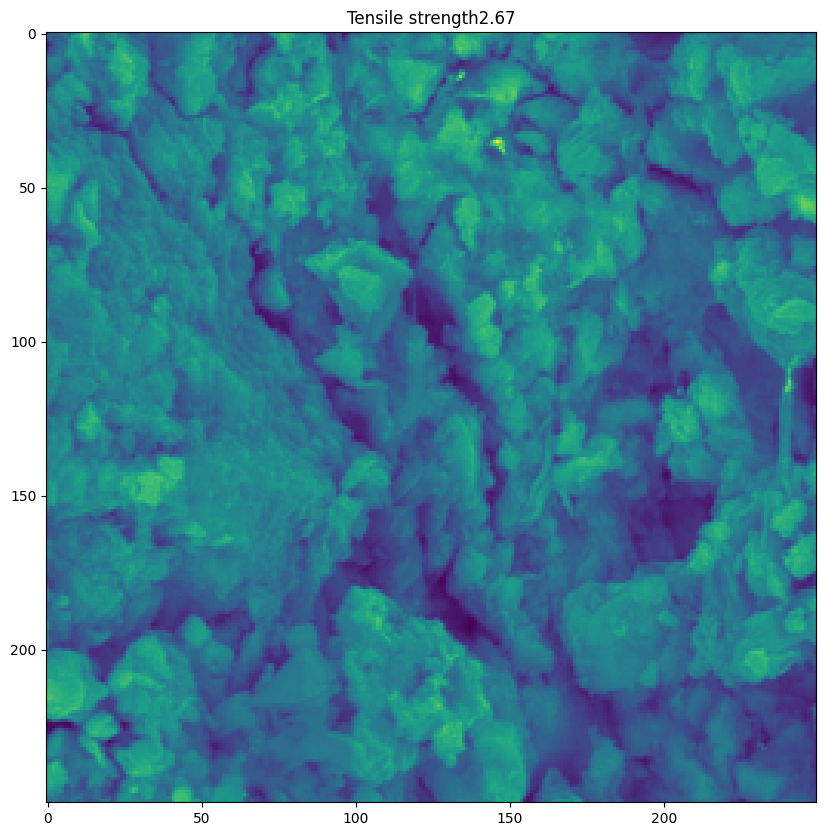

In [8]:
#Plot the images
plt.figure(figsize=(10,10))
plt.imshow(images[0])
plt.title("Tensile strength"+str(labels[0]))

In [9]:
train_images, test_images, train_labels, test_labels = train_test_split(final_images, final_labels, test_size=0.15, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [10]:
train_images = tf.convert_to_tensor(train_images/255, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)

test_images = tf.convert_to_tensor((test_images)/255, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

val_images = tf.convert_to_tensor(val_images/255, dtype=tf.float32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.float32)

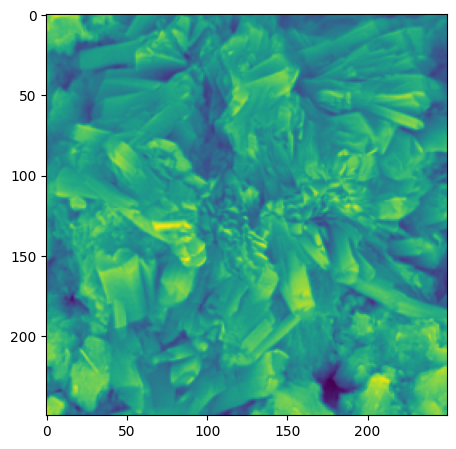

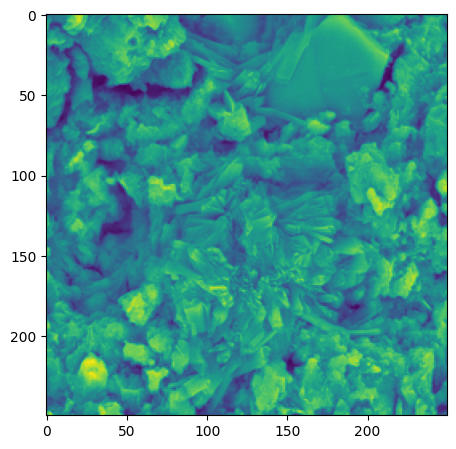

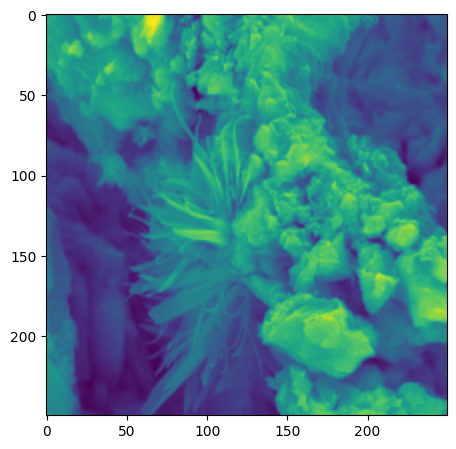

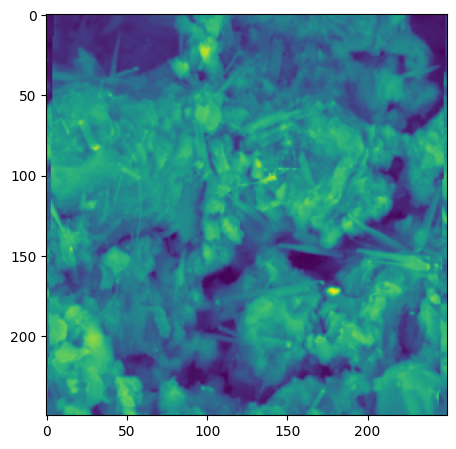

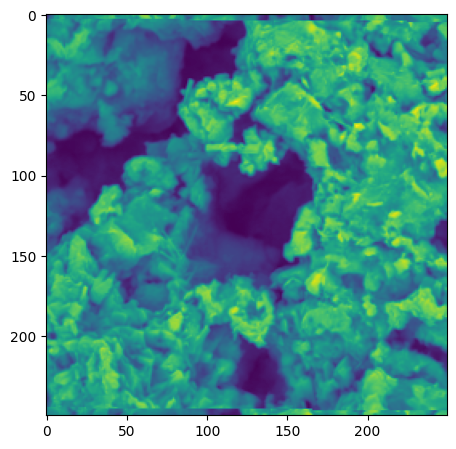

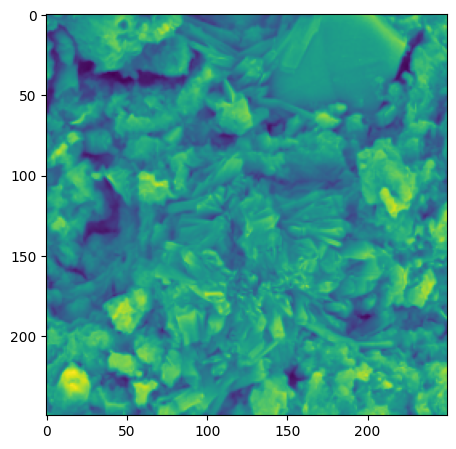

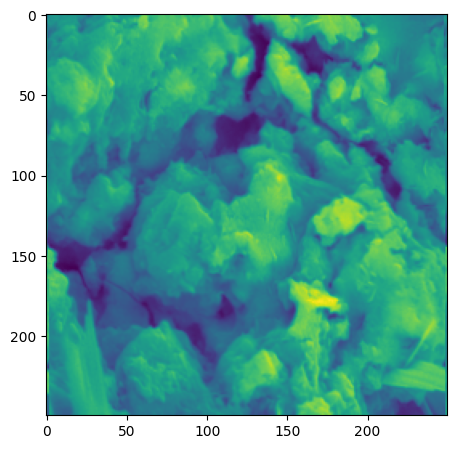

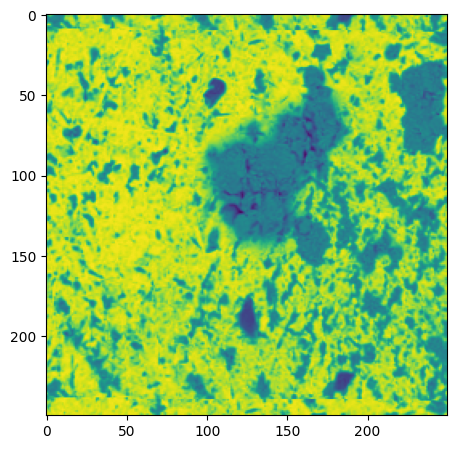

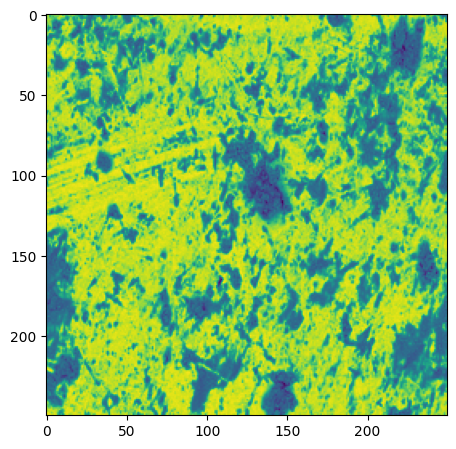

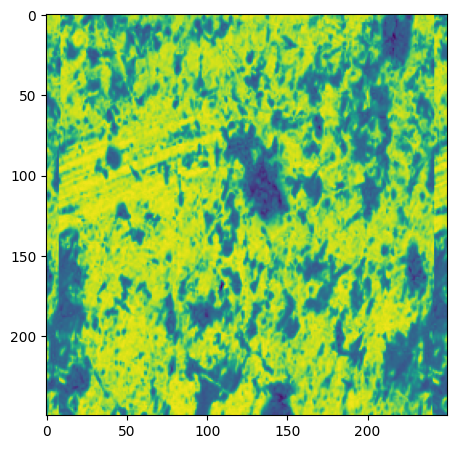

In [11]:
#Plot the generated images
for i in range(10):
  plt.figure(figsize=(30,30))
  plt.subplot(2,5,i+1)
  plt.imshow(train_images[i])


# HyperParameter optimization

## Functions

In [12]:
# Function to convert grayscale to RGB (3 channels). Inception V3 is pre-trained for RGB images
def preprocess_grayscale_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

# Define the custom accuracy metric
def custom_accuracy(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred) / K.maximum(K.abs(y_true), K.epsilon()), axis=-1)

## Hyperparameter model

In [13]:
# Input shape for grayscale images
input_shape = (250, 250, 1)

def hp_model(hp):
    batch_size = hp.Int('batch_size', min_value=8, max_value=32, step=6)
    base_model = InceptionV3(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Lambda(preprocess_grayscale_to_rgb))
    model.add(base_model)

    # Add custom layers
    model.add(layers.GlobalAveragePooling2D())

    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    dense_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
    model.add(layers.Dense(dense_units, activation='relu'))

    model.add(layers.Dense(1))


    # Model compile
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss="mse", metrics=[custom_accuracy])
    return model

## Tuning and search for optimal hyperparameters

In [14]:
tuner = RandomSearch(
    hp_model,
    objective=kt.Objective('val_loss', direction='min'),
    max_trials=15,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='inceptionv3_transfer_learning'
)


lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


tuner.search(train_images, train_labels,
             validation_data=(test_images, test_labels),
             epochs=40,
             callbacks=[lr_reduce, early_stopping])


model = tuner.get_best_models(num_models=1)[0]


test_loss, test_custom_acc = model.evaluate(test_images, test_labels)
print(f"Found model test loss: {test_loss}, Test Accuracy: {test_custom_acc}")

Trial 15 Complete [00h 01m 53s]
val_loss: 0.14907202497124672

Best val_loss So Far: 0.04551998898386955
Total elapsed time: 00h 40m 58s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - custom_accuracy: 0.3032 - loss: 0.0375
Found model test loss: 0.04278535023331642, Test Accuracy: 0.29929134249687195


In [15]:
# Store the optimal hyperparameters in a dictionay
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_hyperparams_dict = {
    'batch_size': best_hps.get('batch_size'),
    'learning_rate': best_hps.get('learning_rate'),
    'dense_units': best_hps.get('dense_units'),
    'dropout_rate': best_hps.get('dropout_rate')
}

print(best_hyperparams_dict)

{'batch_size': 20, 'learning_rate': 0.0004114773318984141, 'dense_units': 64, 'dropout_rate': 0.2}


# Model evaluation

## Build and run the "best" model 20 times to evaluate performance

Run # 1
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 689ms/step - custom_accuracy: 0.4499 - loss: 0.4312 - val_custom_accuracy: 0.2766 - val_loss: 0.1334 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - custom_accuracy: 0.2790 - loss: 0.1430 - val_custom_accuracy: 0.2859 - val_loss: 0.1010 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2824 - loss: 0.1084 - val_custom_accuracy: 0.2779 - val_loss: 0.0830 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - custom_accuracy: 0.2853 - loss: 0.0980 - val_custom_accuracy: 0.2911 - val_loss: 0.0727 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - custom_accuracy: 0.2902 - loss: 0.1085 - val_custom_accuracy: 0.3107 - val_loss: 0.0742 - learning_rate: 4.1148e-04
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - custom_accuracy: 0.3017 - loss: 0.0900 - val_custom_accuracy: 0.2956 - val_loss: 0.0645 - le

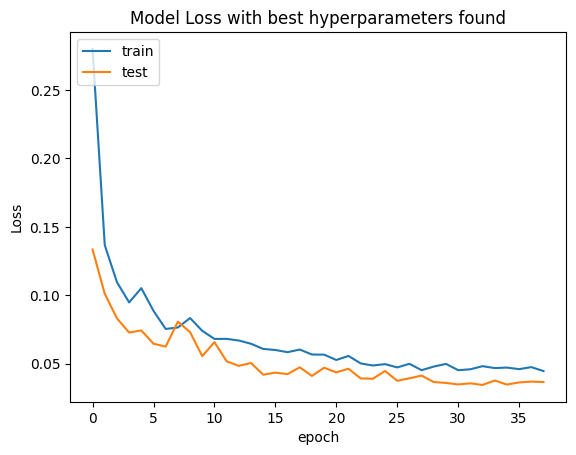

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step
Hits within 5% error: 0.875
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - custom_accuracy: 0.2736 - loss: 0.0265
Run # 2
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 483ms/step - custom_accuracy: 0.4492 - loss: 0.4259 - val_custom_accuracy: 0.2968 - val_loss: 0.1745 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2874 - loss: 0.1488 - val_custom_accuracy: 0.2651 - val_loss: 0.1155 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2754 - loss: 0.1152 - val_custom_accuracy: 0.2817 - val_loss: 0.0913 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - custom_accuracy: 0.2850 - loss: 0.1172 - val_custom_accuracy: 0.3064 - val_loss: 0.1203 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2927 - loss: 0.1133 - val_custom_accuracy: 0.2822 - val_loss: 0.

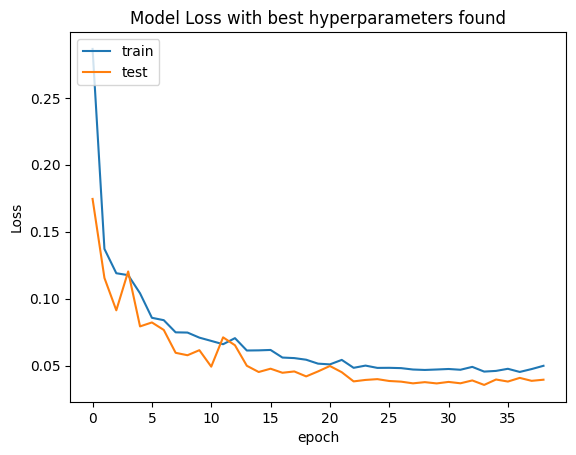

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.84375
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - custom_accuracy: 0.2729 - loss: 0.0273
Run # 3
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 488ms/step - custom_accuracy: 0.4464 - loss: 0.4134 - val_custom_accuracy: 0.2910 - val_loss: 0.1616 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2811 - loss: 0.1444 - val_custom_accuracy: 0.2756 - val_loss: 0.1014 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - custom_accuracy: 0.2765 - loss: 0.1147 - val_custom_accuracy: 0.2881 - val_loss: 0.1083 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2836 - loss: 0.1122 - val_custom_accuracy: 0.2760 - val_loss: 0.0915 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2811 - loss: 0.1010 - val_custom_accuracy: 0.2913 - val_loss: 0

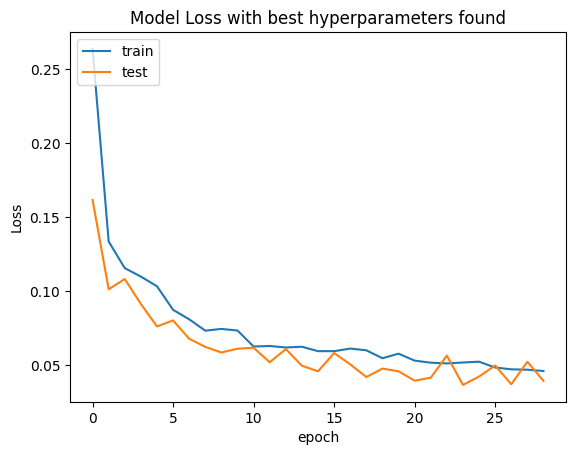

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.640625
Hits within 10% error: 0.953125
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - custom_accuracy: 0.2768 - loss: 0.0350
Run # 4
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - custom_accuracy: 0.4348 - loss: 0.4114 - val_custom_accuracy: 0.3007 - val_loss: 0.1535 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - custom_accuracy: 0.2979 - loss: 0.1601 - val_custom_accuracy: 0.2868 - val_loss: 0.1328 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2905 - loss: 0.1411 - val_custom_accuracy: 0.2896 - val_loss: 0.1247 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2830 - loss: 0.1185 - val_custom_accuracy: 0.2842 - val_loss: 0.0903 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - custom_accuracy: 0.2862 - loss: 0.1066 - val_custom_accuracy: 0.2783 - val_loss:

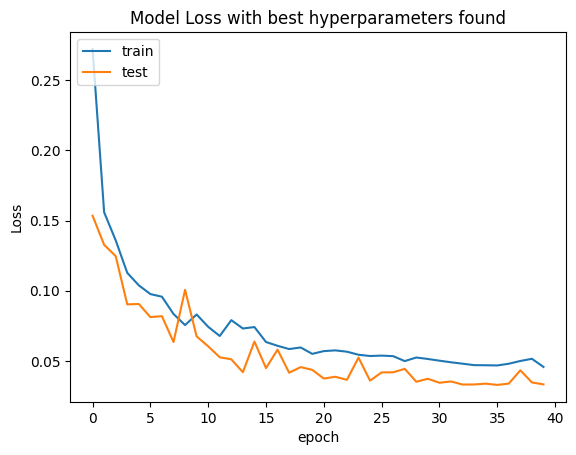

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.875
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - custom_accuracy: 0.2720 - loss: 0.0261
Run # 5
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 480ms/step - custom_accuracy: 0.4505 - loss: 0.4148 - val_custom_accuracy: 0.2861 - val_loss: 0.1446 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2861 - loss: 0.1412 - val_custom_accuracy: 0.2822 - val_loss: 0.1045 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2824 - loss: 0.1158 - val_custom_accuracy: 0.2846 - val_loss: 0.0916 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2817 - loss: 0.1056 - val_custom_accuracy: 0.2781 - val_loss: 0.0855 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2771 - loss: 0.0985 - val_custom_accuracy: 0.2884 - val_loss: 0.

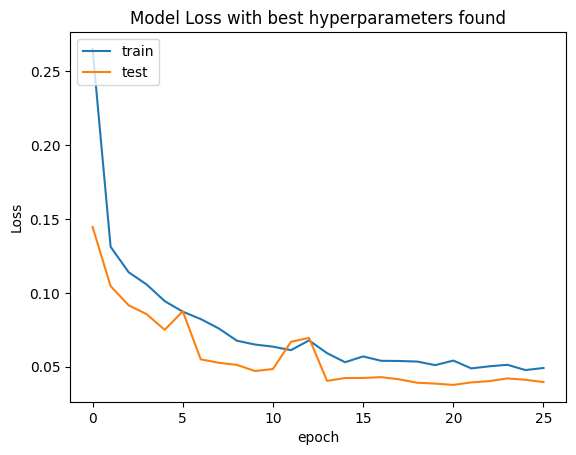

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step
Hits within 5% error: 0.75
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - custom_accuracy: 0.2737 - loss: 0.0333
Run # 6
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 486ms/step - custom_accuracy: 0.3812 - loss: 0.3416 - val_custom_accuracy: 0.2770 - val_loss: 0.1642 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2829 - loss: 0.1483 - val_custom_accuracy: 0.2785 - val_loss: 0.1054 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2869 - loss: 0.1277 - val_custom_accuracy: 0.2882 - val_loss: 0.0936 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - custom_accuracy: 0.2852 - loss: 0.1072 - val_custom_accuracy: 0.3000 - val_loss: 0.0948 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - custom_accuracy: 0.2879 - loss: 0.0934 - val_custom_accuracy: 0.3111 - val_loss: 0.0

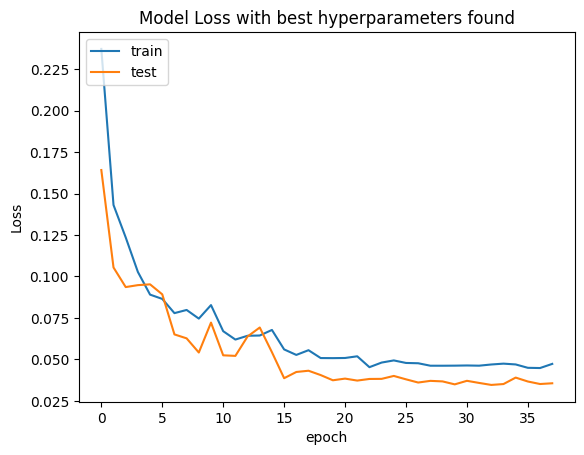

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step
Hits within 5% error: 0.859375
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - custom_accuracy: 0.2778 - loss: 0.0289
Run # 7
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 484ms/step - custom_accuracy: 0.3621 - loss: 0.3386 - val_custom_accuracy: 0.2734 - val_loss: 0.1231 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2831 - loss: 0.1431 - val_custom_accuracy: 0.2704 - val_loss: 0.0930 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2818 - loss: 0.1104 - val_custom_accuracy: 0.2928 - val_loss: 0.0803 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2855 - loss: 0.1097 - val_custom_accuracy: 0.2970 - val_loss: 0.0779 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2931 - loss: 0.0945 - val_custom_accuracy: 0.3083 - val_loss:

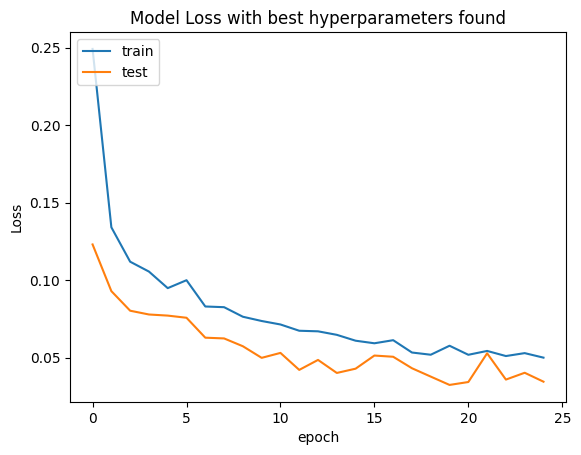

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.8125
Hits within 10% error: 0.96875
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - custom_accuracy: 0.2752 - loss: 0.0324
Run # 8
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 482ms/step - custom_accuracy: 0.4534 - loss: 0.4144 - val_custom_accuracy: 0.2784 - val_loss: 0.1373 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2816 - loss: 0.1390 - val_custom_accuracy: 0.2657 - val_loss: 0.1133 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2748 - loss: 0.1127 - val_custom_accuracy: 0.2742 - val_loss: 0.0856 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2779 - loss: 0.1036 - val_custom_accuracy: 0.2799 - val_loss: 0.0812 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2779 - loss: 0.0982 - val_custom_accuracy: 0.2914 - val_loss: 0.0

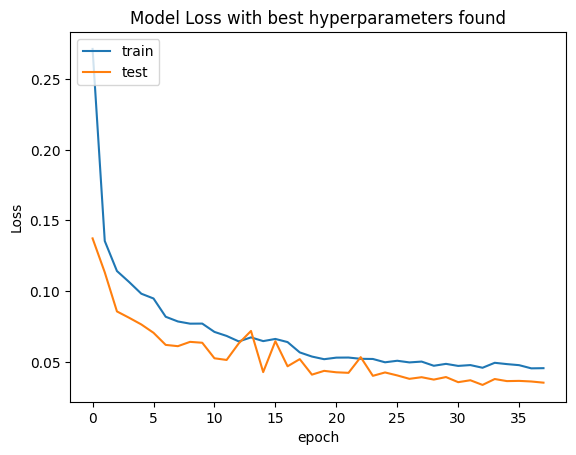

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step
Hits within 5% error: 0.84375
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - custom_accuracy: 0.2728 - loss: 0.0274
Run # 9
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 489ms/step - custom_accuracy: 0.4505 - loss: 0.4329 - val_custom_accuracy: 0.2757 - val_loss: 0.1614 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2841 - loss: 0.1568 - val_custom_accuracy: 0.2756 - val_loss: 0.1156 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2770 - loss: 0.1160 - val_custom_accuracy: 0.2838 - val_loss: 0.0931 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2866 - loss: 0.1018 - val_custom_accuracy: 0.2970 - val_loss: 0.0859 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2845 - loss: 0.0910 - val_custom_accuracy: 0.2913 - val_loss: 

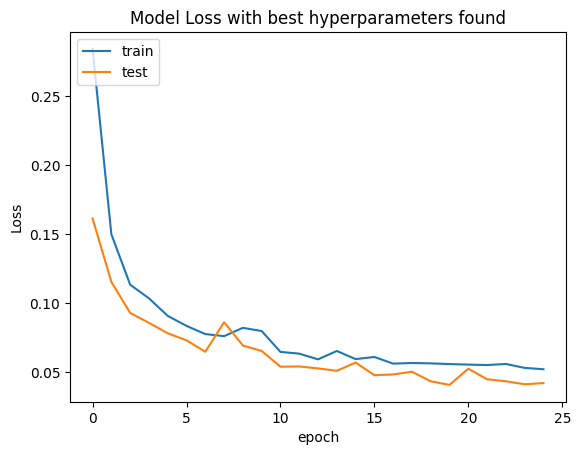

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.71875
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - custom_accuracy: 0.2789 - loss: 0.0361
Run # 10
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 481ms/step - custom_accuracy: 0.3828 - loss: 0.3486 - val_custom_accuracy: 0.2601 - val_loss: 0.1303 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2766 - loss: 0.1363 - val_custom_accuracy: 0.2738 - val_loss: 0.1012 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2805 - loss: 0.1192 - val_custom_accuracy: 0.2919 - val_loss: 0.0904 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2869 - loss: 0.0983 - val_custom_accuracy: 0.2816 - val_loss: 0.0727 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2841 - loss: 0.0948 - val_custom_accuracy: 0.2904 - val_loss: 

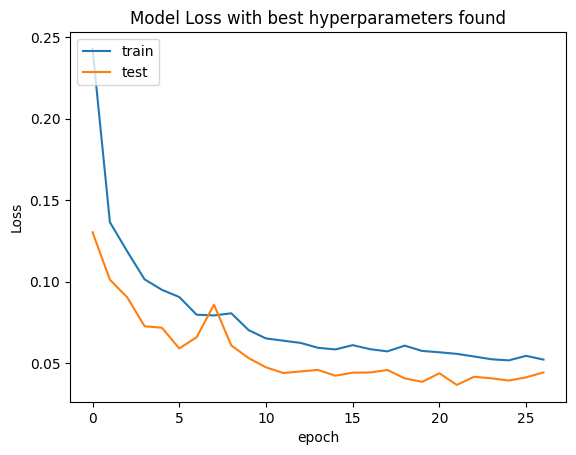

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step
Hits within 5% error: 0.8125
Hits within 10% error: 0.96875
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - custom_accuracy: 0.2749 - loss: 0.0325
Run # 11
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 489ms/step - custom_accuracy: 0.4775 - loss: 0.4492 - val_custom_accuracy: 0.2843 - val_loss: 0.1348 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2869 - loss: 0.1448 - val_custom_accuracy: 0.2743 - val_loss: 0.0929 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - custom_accuracy: 0.2827 - loss: 0.1191 - val_custom_accuracy: 0.2807 - val_loss: 0.0955 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - custom_accuracy: 0.2797 - loss: 0.1063 - val_custom_accuracy: 0.2884 - val_loss: 0.0777 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - custom_accuracy: 0.2840 - loss: 0.1027 - val_custom_accuracy: 0.3042 - val_loss: 0

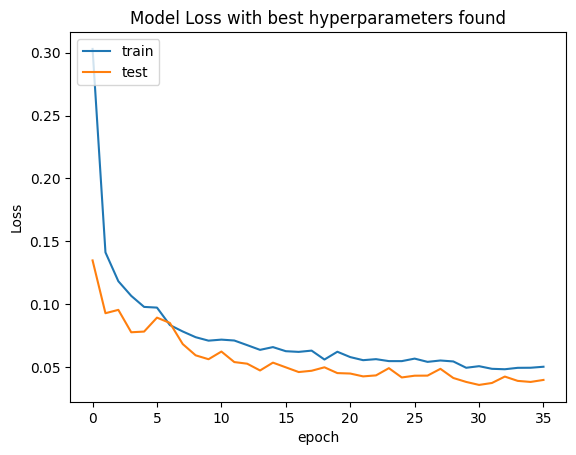

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step
Hits within 5% error: 0.828125
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - custom_accuracy: 0.2723 - loss: 0.0282
Run # 12
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 471ms/step - custom_accuracy: 0.4397 - loss: 0.4145 - val_custom_accuracy: 0.2728 - val_loss: 0.1477 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2867 - loss: 0.1464 - val_custom_accuracy: 0.2797 - val_loss: 0.1074 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - custom_accuracy: 0.2941 - loss: 0.1337 - val_custom_accuracy: 0.2780 - val_loss: 0.1006 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2869 - loss: 0.1102 - val_custom_accuracy: 0.3103 - val_loss: 0.0951 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2970 - loss: 0.1051 - val_custom_accuracy: 0.2928 - val_loss:

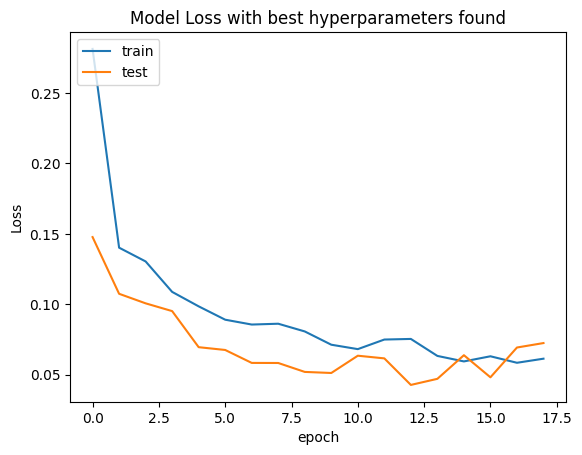

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.671875
Hits within 10% error: 0.96875
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - custom_accuracy: 0.2680 - loss: 0.0398
Run # 13
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 564ms/step - custom_accuracy: 0.4014 - loss: 0.3683 - val_custom_accuracy: 0.2816 - val_loss: 0.1371 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2831 - loss: 0.1326 - val_custom_accuracy: 0.2801 - val_loss: 0.1169 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2858 - loss: 0.1108 - val_custom_accuracy: 0.2835 - val_loss: 0.0993 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2815 - loss: 0.1042 - val_custom_accuracy: 0.2876 - val_loss: 0.0785 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2882 - loss: 0.0948 - val_custom_accuracy: 0.2900 - val_loss:

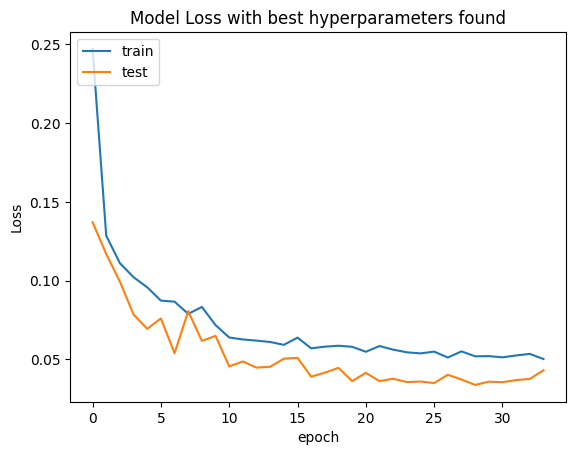

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.78125
Hits within 10% error: 0.96875
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - custom_accuracy: 0.2768 - loss: 0.0314
Run # 14
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 470ms/step - custom_accuracy: 0.4313 - loss: 0.4148 - val_custom_accuracy: 0.2889 - val_loss: 0.1530 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2895 - loss: 0.1462 - val_custom_accuracy: 0.2707 - val_loss: 0.0993 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - custom_accuracy: 0.2753 - loss: 0.1150 - val_custom_accuracy: 0.2799 - val_loss: 0.0900 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - custom_accuracy: 0.2821 - loss: 0.1050 - val_custom_accuracy: 0.2871 - val_loss: 0.0947 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - custom_accuracy: 0.2825 - loss: 0.0985 - val_custom_accuracy: 0.2906 - val_loss: 

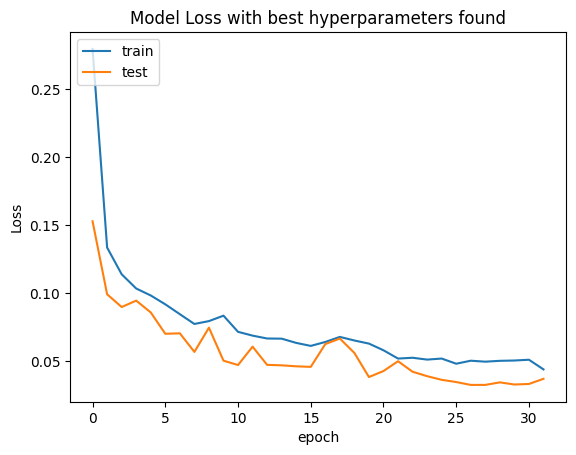

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.71875
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - custom_accuracy: 0.2740 - loss: 0.0345
Run # 15
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 479ms/step - custom_accuracy: 0.4907 - loss: 0.4759 - val_custom_accuracy: 0.2872 - val_loss: 0.1531 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2899 - loss: 0.1481 - val_custom_accuracy: 0.2722 - val_loss: 0.1082 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - custom_accuracy: 0.2866 - loss: 0.1214 - val_custom_accuracy: 0.3041 - val_loss: 0.1284 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - custom_accuracy: 0.2886 - loss: 0.1267 - val_custom_accuracy: 0.3064 - val_loss: 0.1169 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - custom_accuracy: 0.2858 - loss: 0.1107
Epoch 5: ReduceLROnPlateau reducing learn

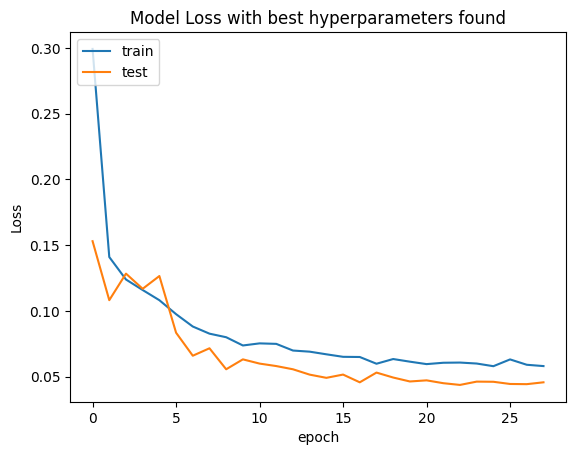

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.703125
Hits within 10% error: 0.953125
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - custom_accuracy: 0.2758 - loss: 0.0388
Run # 16
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 485ms/step - custom_accuracy: 0.4206 - loss: 0.3823 - val_custom_accuracy: 0.2772 - val_loss: 0.1549 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2839 - loss: 0.1502 - val_custom_accuracy: 0.2702 - val_loss: 0.0942 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - custom_accuracy: 0.2777 - loss: 0.1187 - val_custom_accuracy: 0.3023 - val_loss: 0.0980 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2881 - loss: 0.1049 - val_custom_accuracy: 0.2994 - val_loss: 0.0864 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2897 - loss: 0.0943 - val_custom_accuracy: 0.3009 - val_loss

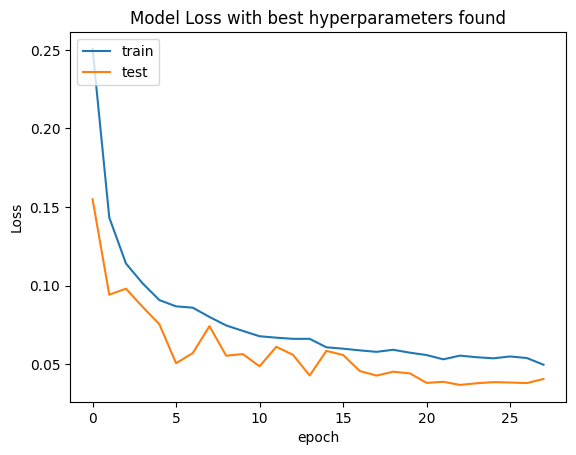

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step
Hits within 5% error: 0.78125
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - custom_accuracy: 0.2707 - loss: 0.0290
Run # 17
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 486ms/step - custom_accuracy: 0.4463 - loss: 0.4245 - val_custom_accuracy: 0.2847 - val_loss: 0.1420 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2925 - loss: 0.1550 - val_custom_accuracy: 0.2910 - val_loss: 0.1124 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - custom_accuracy: 0.2854 - loss: 0.1248 - val_custom_accuracy: 0.3080 - val_loss: 0.1211 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2955 - loss: 0.1193 - val_custom_accuracy: 0.2810 - val_loss: 0.0771 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2821 - loss: 0.0940 - val_custom_accuracy: 0.2947 - val_loss: 

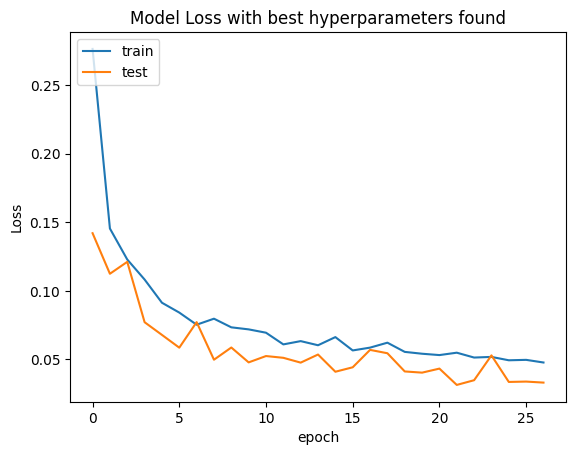

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step
Hits within 5% error: 0.71875
Hits within 10% error: 0.96875
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - custom_accuracy: 0.2717 - loss: 0.0325
Run # 18
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 484ms/step - custom_accuracy: 0.3837 - loss: 0.3514 - val_custom_accuracy: 0.2640 - val_loss: 0.1449 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - custom_accuracy: 0.2813 - loss: 0.1590 - val_custom_accuracy: 0.3235 - val_loss: 0.1510 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.3069 - loss: 0.1521 - val_custom_accuracy: 0.3096 - val_loss: 0.1155 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2997 - loss: 0.1258 - val_custom_accuracy: 0.2966 - val_loss: 0.0823 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.3037 - loss: 0.1074 - val_custom_accuracy: 0.3020 - val_loss: 0

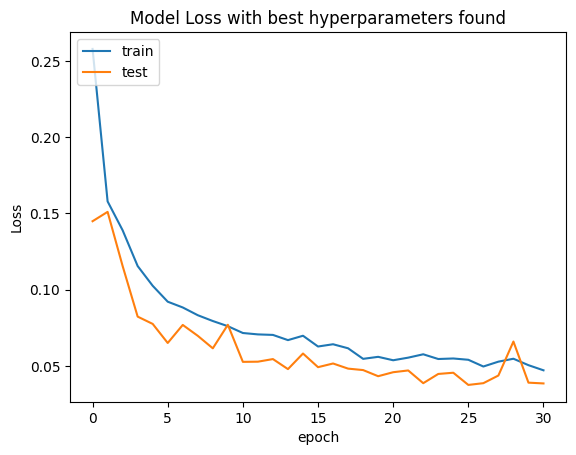

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.75
Hits within 10% error: 0.96875
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - custom_accuracy: 0.2660 - loss: 0.0337
Run # 19
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 490ms/step - custom_accuracy: 0.4417 - loss: 0.4244 - val_custom_accuracy: 0.2813 - val_loss: 0.1580 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2774 - loss: 0.1423 - val_custom_accuracy: 0.2707 - val_loss: 0.1110 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - custom_accuracy: 0.2760 - loss: 0.1135 - val_custom_accuracy: 0.2765 - val_loss: 0.0893 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2797 - loss: 0.1077 - val_custom_accuracy: 0.2827 - val_loss: 0.0829 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - custom_accuracy: 0.2812 - loss: 0.0969 - val_custom_accuracy: 0.2915 - val_loss: 0.08

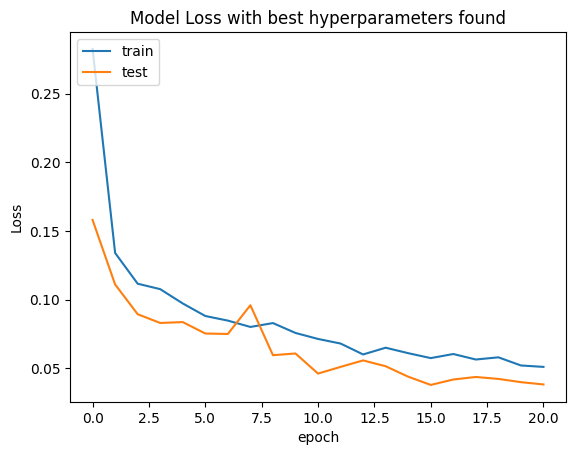

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step
Hits within 5% error: 0.703125
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - custom_accuracy: 0.2727 - loss: 0.0368
Run # 20
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 493ms/step - custom_accuracy: 0.3558 - loss: 0.3188 - val_custom_accuracy: 0.2616 - val_loss: 0.1294 - learning_rate: 4.1148e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - custom_accuracy: 0.2710 - loss: 0.1329 - val_custom_accuracy: 0.2769 - val_loss: 0.0913 - learning_rate: 4.1148e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - custom_accuracy: 0.2824 - loss: 0.0977 - val_custom_accuracy: 0.2915 - val_loss: 0.0774 - learning_rate: 4.1148e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - custom_accuracy: 0.2863 - loss: 0.1042 - val_custom_accuracy: 0.3073 - val_loss: 0.0899 - learning_rate: 4.1148e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - custom_accuracy: 0.2906 - loss: 0.0879 - val_custom_accuracy: 0.2875 - val_loss

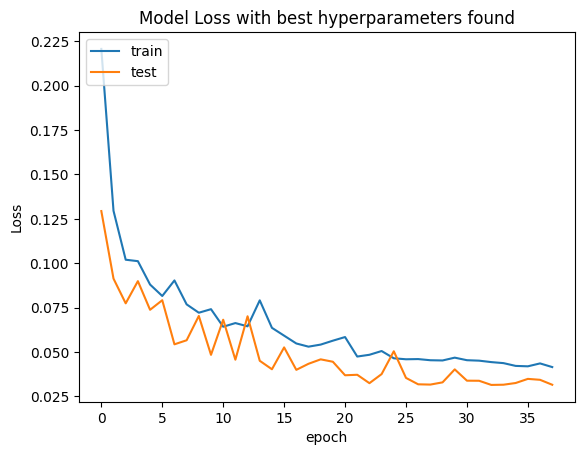

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
Hits within 5% error: 0.84375
Hits within 10% error: 0.984375
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - custom_accuracy: 0.2718 - loss: 0.0265


In [16]:
# Initialize lists to store results
l_hits5 = []
l_hits10 = []
l_loss = []

# Run the model 20 times for statistics
for i in range(20):
  print("Run #", 1+i)
  # Build the model with the tuned hyperparameters using Functional API
  def build_model_with_best_params():
      input_shape = (250, 250, 1)

      inputs = layers.Input(shape=input_shape)


      x = layers.Lambda(preprocess_grayscale_to_rgb)(inputs)


      base_model = InceptionV3(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
      base_model.trainable = False


      x = base_model(x)


      x = layers.GlobalAveragePooling2D()(x)
      x = layers.Dropout(best_hyperparams_dict['dropout_rate'])(x)
      x = layers.Dense(best_hyperparams_dict['dense_units'], activation='relu')(x)


      outputs = layers.Dense(1)(x)


      model = models.Model(inputs=inputs, outputs=outputs)
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparams_dict['learning_rate']),
                    loss=custom_accuracy,
                    metrics=[custom_accuracy])

      return model

  lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model = build_model_with_best_params()


  history = model.fit(train_images, train_labels,
                      epochs=40,
                      batch_size=best_hyperparams_dict['batch_size'],
                      validation_data=(test_images, test_labels),
                      callbacks=[lr_reduce, early_stopping])

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss with best hyperparameters found')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


  predictions_test = model.predict(val_images)

  count = 0
  for i in range(len(predictions_test)):
      error = float(abs(predictions_test[i] - val_labels[i]) * 100 / val_labels[i])
      if error <= 5.00:
          count += 1

  print(f"Hits within 5% error: {count/len(predictions_test)}")
  l_hits5.append(count/len(predictions_test))


  count = 0
  for i in range(len(predictions_test)):
      error = float(abs(predictions_test[i] - val_labels[i]) * 100 / val_labels[i])
      if error <= 10.00:
          count += 1

  print(f"Hits within 10% error: {count/len(predictions_test)}")
  l_hits10.append(count/len(predictions_test))

  loss = model.evaluate(val_images, val_labels)
  l_loss.append(loss[1])

## Statistics

In [17]:
mean5 = statistics.mean(l_hits5)
mean10 = statistics.mean(l_hits10)
mean_loss = statistics.mean(l_loss)


stdev5 = statistics.stdev(l_hits5)
stdev10 = statistics.stdev(l_hits10)
stdev_loss = statistics.stdev(l_loss)


print(f"Mean (5% margin): {mean5}")
print(f"Mean (10% margin): {mean10}")
print(f"Mean Loss: {mean_loss}\n")
print(f"Standard Deviation (5% margin): {stdev5}")
print(f"Standard Deviation (10% margin): {stdev10}")
print(f"Standard Deviation Loss: {stdev_loss}")


Mean (5% margin): 0.7765625
Mean (10% margin): 0.9765625
Mean Loss: 0.2952239453792572

Standard Deviation (5% margin): 0.07135106520984075
Standard Deviation (10% margin): 0.010753862525182583
Standard Deviation Loss: 0.0034303657468532584


# Save the trained model

In [18]:
model.save('optimal_hyperparameters_transfer_learning_model.h5')

# Predictions of images property

In [19]:
predictions = model.predict(images/255)

count = 0
for i in range(len(predictions)):
    error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
    if error <= 5.00:
        count += 1

print(f"Hits within 5% error: {count/len(predictions)}")



count = 0
for i in range(len(predictions)):
    error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
    if error <= 10.00:
        count += 1

print(f"Hits within 10% error: {count/len(predictions)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Hits within 5% error: 0.8181818181818182
Hits within 10% error: 0.8863636363636364


<ipython-input-19-a6efc4c3bbff>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
<ipython-input-19-a6efc4c3bbff>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])


# Save hyperparameters tunings (optional)

In [ ]:
!zip -r /content/drive/MyDrive/file.zip /content/hyperparam_tuning

  adding: content/hyperparam_tuning/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/trial.json (deflated 67%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/build_config.json (deflated 11%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/checkpoint.weights.h5 (deflated 8%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/trial.json (deflated 67%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/build_config.json (deflated 11%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/checkpoint.weights.h5 (deflated 8%)
  adding: content/hyperparam_tuning/inceptionv3_transfer